# Libraries

In [1]:
import os  # Для работы с файловой системой
import sep  # Для извлечения и анализа источников на астрономических изображениях
import pandas as pd  # Для работы с таблицами данных
import matplotlib.pyplot as plt  # Для построения графиков и визуализации данных
from astropy.io import fits  # Для чтения и записи FITS файлов, стандартного формата астрономических данных
from astropy.wcs import WCS  # Для работы с мировой координатной системой (WCS) в астрономических изображениях
from matplotlib.patches import Circle  # Для рисования кругов на графиках
import numpy as np  # Для работы с массивами чисел и выполнения численных операций
from scipy.stats import norm  # Для работы со статистическим нормальным распределением
from scipy.optimize import curve_fit
from astropy.stats import sigma_clipped_stats  # Для расчета статистик с исключением выбросов (сигма-клиппинг)
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Для создания делимых областей на графиках
from concurrent.futures import ThreadPoolExecutor  # Для параллельного выполнения задач
from astropy.visualization import ZScaleInterval, MinMaxInterval  # Для масштабирования изображений
import time
from tqdm import tqdm
from astroquery.gaia import Gaia
from scipy.ndimage import gaussian_filter
import cv2
from concurrent.futures import ThreadPoolExecutor
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord 

# Functions

## Background

In [178]:
def subtract_background(fits_file, output_directory, bw, bh, fw, fh, data=None, header=None):
    """
    Выполняет вычитание фона из данных FITS файла и сохраняет результат.

    Параметры:
    fits_file : str
        Путь к входному FITS файлу.
    output_directory : str
        Путь к выходному каталогу для сохранения обработанных файлов.
    bw : int
        Ширина блока для оценки фона.
    bh : int
        Высота блока для оценки фона.
    fw : int
        Ширина фильтра для сглаживания фона.
    fh : int
        Высота фильтра для сглаживания фона.

    Возвращаемые значения:
    data_sub : ndarray
        Данные с вычитанным фоном.
    bkg : sep.Background
        Объект фона.
    header : astropy.io.fits.Header
        Заголовок FITС файла.
    """
    print(f"Processing file: {fits_file}")
    if data is None:
        hdul = fits.open(fits_file)
        data = hdul[0].data
        header = hdul[0].header
        
    file_name = fits_file.split("/")[-1].replace(".fits", "").replace(".fit", "")
    if data is None or data.size == 0:
        print(f"Warning: No data in FITС file {fits_file}")
        return None, None, None

    data = data.astype(np.float32)
    
    bkg = sep.Background(data, bw=bw, bh=bh, fw=fw, fh=fh)
    data_sub = data - bkg
    file_name = fits_file.split("/")[-1].replace(".fit","").replace(".fits","")
    
    # hdul_sub =fits.PrimaryHDU(data=data)
    # hdul_sub.writeto(output_directory + file_name + "_sub.fits", overwrite=True)
    
    mean_data, median_data, std_data = sigma_clipped_stats(data, sigma=3.0)
    mean_data_sub, median_data_sub, std_data_sub = sigma_clipped_stats(data_sub, sigma=3.0)
    mean_bkg, median_bkg, std_bkg = sigma_clipped_stats(bkg.back(), sigma=3.0)
    
    # Создание фигуры и осей
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))
    
    # Initial frame
    axs[0].hist(data.ravel(), bins=256, histtype='step', color='black')
    axs[0].axvline(x=mean_data, color='r', linestyle='--', label=f'Mean: {mean_data:.1f}')
    axs[0].axvline(x=mean_data + std_data, color='g', linestyle='--', label=f'STD: {std_data:.1f}')
    axs[0].axvline(x=mean_data - std_data, color='g', linestyle='--')
    axs[0].set_xlim([mean_data - 5*std_data, mean_data + 5*std_data])
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].set_title('Initial frame')
    axs[0].set_xlabel('Pixel Value')
    axs[0].set_ylabel('Frequency')
    axs[0].legend(loc="upper right")
    
    # Background
    axs[1].hist(bkg.back().ravel(), bins=256, histtype='step', color='black')
    axs[1].axvline(x=mean_bkg, color='r', linestyle='--', label=f'Mean: {mean_bkg:.1f}')
    axs[1].axvline(x=mean_bkg + std_bkg, color='g', linestyle='--', label=f'STD: {std_bkg:.1f}')
    axs[1].axvline(x=mean_bkg - std_bkg, color='g', linestyle='--')
    axs[1].set_xlim([mean_bkg - 5*std_data, mean_bkg + 5*std_data])
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].set_title('Background')
    axs[1].set_xlabel('Pixel Value')
    axs[1].set_ylabel('Frequency')
    axs[1].legend(loc="upper right")
    
    # Distribution with X-Limits after subtraction
    axs[2].hist(data_sub.ravel(), bins=256, histtype='step', color='black')
    axs[2].axvline(x=mean_data_sub, color='r', linestyle='--', label=f'Mean: {mean_data_sub:.1f}')
    axs[2].axvline(x=mean_data_sub + std_data_sub, color='g', linestyle='--', label=f'STD: {std_data_sub:.1f}')
    axs[2].axvline(x=mean_data_sub - std_data_sub, color='g', linestyle='--')
    axs[2].set_xlim([mean_data_sub - 5*std_data_sub, mean_data_sub + 5*std_data_sub])
    axs[2].set_title('Distribution after subtraction')
    axs[2].set_xlabel('Pixel Value')
    axs[2].set_ylabel('Frequency')
    axs[2].legend(loc="upper right")
    axs[2].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f'{file_name}_pix_distrib.png'), dpi=300)
    plt.show()

    # Построение изображений с правильными размерами colorbar
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Первое изображение
    img0 = axs[0].imshow(data, cmap='gray', origin='lower')
    axs[0].set_title('Initial data')
    divider0 = make_axes_locatable(axs[0])
    cax0 = divider0.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax0)
    
    # Второе изображение
    img1 = axs[1].imshow(data_sub, cmap='gray', origin='lower')
    axs[1].set_title('Data after Background Subtraction')
    divider1 = make_axes_locatable(axs[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax1)
    
    # Третье изображение
    img2 = axs[2].imshow(bkg.back(), cmap='gray', origin='lower')
    axs[2].set_title('Background')
    divider2 = make_axes_locatable(axs[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img2, cax=cax2)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f'{file_name}_sub_comparison.png'), dpi=300)
    plt.show()

    return data_sub, bkg, header

# Обновлённая функция для поиска минимальной ошибки и минимального значения
def evaluate_background_params(data, bw, bh, fw, fh):
    """
    Оценивает параметры фона для данных, возвращая как RMS шума, так и минимальное значение вычтенного фона.
    """
    # Оценка фона
    bkg = sep.Background(data, bw=bw, bh=bh, fw=fw, fh=fh)
    data_sub = data - bkg.back()  # Вычитание фона

    # RMS шума и минимальное значение
    rms = bkg.globalrms
    min_val = np.min(data_sub)  # Минимальное значение после вычитания фона
    
    return rms, min_val, (bw, bh, fw, fh)

# Глобальные переменные для хранения лучших параметров
best_params_glob = []

def find_best_params_balanced(fits_file, output_directory, data=None):
    """
    Находит наилучшие параметры для вычитания фона, исключая заранее плохие варианты,
    с использованием первичного фильтра и балансировки метрик через Евклидово расстояние.
    
    Параметры:
    fits_file : str
        Путь к FITS файлу.
    output_directory : str
        Путь к каталогу для сохранения выходных изображений.
    data : ndarray, optional
        Данные изображения, если уже загружены.
    
    Возвращаемые значения:
    best_params : tuple
        Наилучшие параметры (bw, bh, fw, fh).
    all_results : list
        Список всех результатов в виде (min_val, rms, params).
    """
    global best_rms_params, best_min_val_params  # Объявляем глобальные переменные

    if data is None:
        with fits.open(fits_file) as hdul:
            data = hdul[0].data.astype(np.float32)
    
    file_name = fits_file.split("/")[-1].replace(".fits", "").replace(".fit", "")

    # Параметры для перебора (исключаем заранее плохие параметры, например bw=32, fw=3)
    bw_values = [32, 64, 128]
    fw_values = [3, 5, 7]

    all_results = []

    # Многопоточная оценка всех параметров
    with ThreadPoolExecutor() as executor:
        futures = []
        for bw in bw_values:
            for fw in fw_values:
                futures.append(executor.submit(evaluate_background_params, data, bw, bw, fw, fw))

        for future in futures:
            rms, min_val, params = future.result()
            all_results.append((min_val, rms, params))

    # Сортируем результаты по значениям bw и fw
    all_results.sort(key=lambda x: (x[2][0], x[2][2]))  # Сортировка по bw, потом по fw

    # Нормируем значения RMS и минимальных значений
    min_vals = np.array([result[0] for result in all_results])
    rms_vals = np.array([result[1] for result in all_results])

    norm_min_vals = (min_vals - np.min(min_vals)) / (np.max(min_vals) - np.min(min_vals))
    norm_rms_vals = (rms_vals - np.min(rms_vals)) / (np.max(rms_vals) - np.min(rms_vals))

    # Рассчитываем Евклидово расстояние от точки (0, 0)
    distances = np.sqrt(norm_min_vals**2 + norm_rms_vals**2)

    # Выбираем параметры с минимальным расстоянием
    best_index = np.argmin(distances)
    best_params = all_results[best_index][2]
    best_params_glob = best_params
    # Создаём подписи для графиков в нужном порядке
    param_values = [f'bw={result[2][0]}, fw={result[2][2]}' for result in all_results]
    
    # Построение графиков для RMS ошибок и минимальных значений
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # График для RMS ошибок
    axs[0].plot(param_values, rms_vals, 'o-', label='RMS Errors')
    axs[0].plot(param_values[best_index], rms_vals[best_index], 'r*', label='Best RMS', markersize=15)
    axs[0].set_xlabel('Parameters (bw, fw)')
    axs[0].set_ylabel('RMS Error')
    axs[0].set_title('RMS Error vs Parameters')
    axs[0].legend()
    axs[0].grid(alpha=0.25, lw=1, ls="-")
    axs[0].tick_params(axis='x', rotation=45)

    # График для минимальных значений
    axs[1].plot(param_values, np.abs(min_vals), 's-', label='Min Value Deviations')
    axs[1].plot(param_values[best_index], np.abs(min_vals[best_index]), 'r*', label='Best Min Value', markersize=15)
    axs[1].set_xlabel('Parameters (bw, fw)')
    axs[1].set_ylabel('Absolute Min Value')
    axs[1].set_title('Min Value vs Parameters')
    axs[1].legend()
    axs[1].grid(alpha=0.25, lw=1, ls="-")
    axs[1].tick_params(axis='x', rotation=45)

    # Сохраняем и показываем графики
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f'{file_name}_rms_minval_subplots.png'))
    plt.show()

    # Нормируем значения RMS и минимальных значений к диапазону [0, 1]
    norm_rms_vals = (rms_vals - np.min(rms_vals)) / (np.max(rms_vals) - np.min(rms_vals))
    norm_min_val_values = (np.abs(min_vals) - np.min(np.abs(min_vals))) / (np.max(np.abs(min_vals)) - np.min(np.abs(min_vals)))

    # Предположим, что norm_min_vals, norm_rms_vals, param_values и best_index уже вычислены

    # Код для построения двух графиков в одном сабплоте
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    # Первый график: Линии от каждой точки к (0, 0) на графике norm_min_vals и norm_rms_vals
    for i, (x, y) in enumerate(zip(norm_min_vals, norm_rms_vals)):
        axs[0].plot([0, x], [0, y], label=param_values[i], linestyle='-', marker='o', markersize=8)
    
    # Добавление звездочки после всех точек, чтобы она была сверху
    axs[0].scatter(norm_min_vals[best_index], norm_rms_vals[best_index], color='red', marker='*', s=300, label='Best Params')
    
    # Добавление подписи рядом с оптимальной точкой
    axs[0].text(norm_min_vals[best_index]+0.03, norm_rms_vals[best_index]-0.03, param_values[best_index],
                color='gray', fontsize=10, ha='left', va='bottom')
    
    axs[0].set_xlabel('Normalized Min Values')
    axs[0].set_ylabel('Normalized RMS Values')
    axs[0].set_title('Connection to (0, 0) for each parameter')
    axs[0].legend()
    axs[0].grid(True)
    
    # Второй график: нормализованные RMS ошибки и минимальные значения
    axs[1].plot(param_values, norm_rms_vals, 'o-', label='Normalized RMS Errors', markersize=8)
    
    # График для нормированных минимальных значений
    axs[1].plot(param_values, norm_min_val_values, 's-', label='Normalized Min Value Deviations', markersize=8)
    
    # Сначала точки, а затем звездочки для перекрытия
    axs[1].scatter(param_values[best_index], norm_rms_vals[best_index], color='red', marker='*', s=300, label='Best RMS')
    axs[1].scatter(param_values[best_index], norm_min_val_values[best_index], color='red', marker='*', s=300, label='Best Min Value')
    
    axs[1].set_xlabel('Parameters (bw, fw)')
    axs[1].set_ylabel('Normalized Values (RMS & Min Value)')
    axs[1].set_title('Normalized RMS Error and Min Value vs Parameters')
    axs[1].legend()
    
    axs[1].grid(alpha=0.25, lw=1, ls="-")
    axs[1].tick_params(axis='x', rotation=45)
    
    # Сохраняем и показываем графики
    plt.tight_layout()
    plt.show()
        

    return best_params, all_results



## Objects

In [176]:
# def extract_and_export_objects(data_sub, bkg, header, output_directory, fits_file):
#     """
#     Извлекает объекты из данных с вычитанным фоном и сохраняет их параметры в CSV файл.
#     Также создаёт отдельный CSV файл с 10 самыми яркими объектами.

#     Параметры:
#     data_sub : ndarray
#         Данные с вычитанным фоном.
#     bkg : sep.Background
#         Объект фона.
#     header : astropy.io.fits.Header
#         Заголовок FITС файла.
#     output_directory : str
#         Путь к выходному каталогу для сохранения обработанных файлов.
#     fits_file : str
#         Путь к исходному FITС файлу для сохранения имени.

#     Возвращаемые значения:
#     df : pandas.DataFrame
#         Таблица с параметрами объектов.
#     """
#     if data_sub is None or bkg is None or header is None:
#         print("Invalid input data.")
#         return None, None

#     mean_data_sub, median_data_sub, std_data_sub = sigma_clipped_stats(data_sub, sigma=3.0)
    
#     err = bkg.globalrms
#     print(err)
#     thresh = -10 #Динамический порог обнаружения на основе фонового шума
#     minarea = 15
#     deblend_nthresh = 32 #количество уровней для разделения объектов
#     deblend_cont = 0.05 #контраст для разделения объектов
#     clean = True #будет ли применяться процедура очистки после разделения объектов
#     clean_param = 1.0 #насколько агрессивно будет проводиться процедура очистки, 1 полезна для шумных изображений 
    
#     sep.set_extract_pixstack(1e7) 
    
#     objects = sep.extract(data_sub, thresh, minarea=minarea, deblend_nthresh=deblend_nthresh,
#                           deblend_cont=deblend_cont, clean=clean, clean_param=clean_param)

#     if len(objects) == 0:
#         print(f"No objects found in {fits_file}")
#         return None, None
#     else:
#         print(f"{len(objects)} objects found in {fits_file}")

#     # # Рассчитываем размеры объектов (например, полуоси 'a' или 'b')
#     # object_sizes = np.sqrt(objects['a'] * objects['b'])
#     # # Рассчитываем средний размер и стандартное отклонение
#     # mean_size = np.mean(object_sizes)
#     # std_size = np.std(object_sizes)
#     # # Устанавливаем максимальный допустимый размер как mean + 3 * std
#     # max_size = mean_size + std_size
#     # # Фильтруем объекты, размеры которых больше допустимого
#     filtered_objects = objects#[object_sizes <= max_size]
    
#     wcs = WCS(header)
#     objects_coords = wcs.all_pix2world(objects['x'], objects['y'], 1)

#     flux, flux_err, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=err, gain=1.0)
#     mag = -2.5 * np.log10(flux)
#     mag_err = 2.5 / np.log(10) * (flux_err / flux)
    
#     data = {
#         'id': range(len(objects)),
#         'x': objects['x'],
#         'y': objects['y'],
#         'ra': objects_coords[0],
#         'dec': objects_coords[1],
#         'flux': flux,
#         'flux_err': flux_err,
#         'mag': mag,
#         'mag_err': mag_err,
#         'flag': flag
#     }

#     # Добавление параметров 'a' и 'b' в таблицу объектов
#     if 'a' in objects.dtype.names and 'b' in objects.dtype.names:
#         data['a'] = objects['a']
#         data['b'] = objects['b']

#     # # Проверяем длины всех массивов в словаре `data`
#     # for key, value in data.items():
#     #     print(f"Length of {key}: {len(value)}")
    
#     df = pd.DataFrame(data)

#     base_name = os.path.splitext(os.path.basename(fits_file))[0]

#     # Сохранение основной таблицы
#     output_csv_file = os.path.join(output_directory, f"{base_name}_objects.csv")
#     df.to_csv(output_csv_file, index=False)


#     return df

def extract_and_export_objects(data_sub, bkg, header, output_directory, fits_file):
    """
    Извлекает объекты из данных с вычитанным фоном и сохраняет их параметры в CSV файл.
    Сегментирует изображение на 4 части и анализирует их по отдельности.

    Параметры:
    data_sub : ndarray
        Данные с вычитанным фоном.
    bkg : sep.Background
        Объект фона.
    header : astropy.io.fits.Header
        Заголовок FITС файла.
    output_directory : str
        Путь к выходному каталогу для сохранения обработанных файлов.
    fits_file : str
        Путь к исходному FITС файлу для сохранения имени.

    Возвращаемые значения:
    df : pandas.DataFrame
        Таблица с параметрами объектов.
    """

    if data_sub is None or bkg is None or header is None:
        print("Invalid input data.")
        return None, None

    # Получаем размеры изображения
    height, width = data_sub.shape

    # Разделяем изображение на 4 части
    segments = [
        data_sub[0:height//2, 0:width//2],  # Верхний левый угол
        data_sub[0:height//2, width//2:],   # Верхний правый угол
        data_sub[height//2:, 0:width//2],   # Нижний левый угол
        data_sub[height//2:, width//2:]     # Нижний правый угол
    ]

    # Создаём пустой список для хранения данных объектов из всех сегментов
    all_objects = []

    # Цикл по сегментам
    for i, segment in enumerate(segments):
        # Преобразование сегмента в C-смежный массив
        segment = np.ascontiguousarray(segment)
        mean_data_sub, median_data_sub, std_data_sub = sigma_clipped_stats(segment, sigma=3.0)
        
        err = bkg.globalrms
        thresh = 0  # Порог на основе фонового шума
        minarea = 10
        deblend_nthresh = 32
        deblend_cont = 0.05
        clean = True
        clean_param = 1.0

        sep.set_extract_pixstack(1e7)

        # Извлечение объектов из текущего сегмента
        objects = sep.extract(segment, thresh, minarea=minarea, deblend_nthresh=deblend_nthresh,
                              deblend_cont=deblend_cont, clean=clean, clean_param=clean_param)

        if len(objects) == 0:
            print(f"No objects found in segment {i+1}")
            continue
        else:
            print(f"{len(objects)} objects found in segment {i+1}")

        # Рассчитываем мировые координаты для объектов
        wcs = WCS(header)
        x_coords = objects['x'] + (0 if i % 2 == 0 else width // 2)
        y_coords = objects['y'] + (0 if i < 2 else height // 2)
        objects_coords = wcs.all_pix2world(x_coords, y_coords, 1)

        flux, flux_err, flag = sep.sum_circle(segment, objects['x'], objects['y'], 3.0, err=err, gain=1.0)
        mag = -2.5 * np.log10(flux)
        mag_err = 2.5 / np.log(10) * (flux_err / flux)

        # Создаём DataFrame для объектов текущего сегмента
        data = {
            'id': range(len(objects)),
            'x': x_coords,
            'y': y_coords,
            'ra': objects_coords[0],
            'dec': objects_coords[1],
            'flux': flux,
            'flux_err': flux_err,
            'mag': mag,
            'mag_err': mag_err,
            'flag': flag
        }

        if 'a' in objects.dtype.names and 'b' in objects.dtype.names:
            data['a'] = objects['a']
            data['b'] = objects['b']

        df_segment = pd.DataFrame(data)
        all_objects.append(df_segment)

    # Объединяем все сегменты в один DataFrame
    if len(all_objects) > 0:
        df = pd.concat(all_objects, ignore_index=True)
    else:
        print(f"No objects found in {fits_file}")
        return None, None

    # Сохранение результатов в CSV
    base_name = os.path.splitext(os.path.basename(fits_file))[0]
    output_csv_file = os.path.join(output_directory, f"{base_name}_objects.csv")
    df.to_csv(output_csv_file, index=False)

    return df

def plot_objects(image_data, image_data_sub, objects, output_dir, file_name, scale='zscale'):
    """
    Визуализирует объекты на изображении и сохраняет результат в файл с возможностью выбора шкалы.

    Параметры:
    image_data : ndarray
        Данные изображения.
    objects : list
        Список объектов, извлеченных из изображения.
    output_image : str
        Путь к файлу для сохранения изображения.
    scale : str
        Шкала для отображения изображения (допустимые значения: 'linear', 'zscale', 'minmax').
    """
    from astropy.visualization import ZScaleInterval, MinMaxInterval

    if scale == 'zscale':
        interval = ZScaleInterval()
    elif scale == 'minmax':
        interval = MinMaxInterval()
    else:
        interval = None

    if interval:
        vmin, vmax = interval.get_limits(image_data)
    else:
        vmin, vmax = 0, np.percentile(image_data, 99)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

    for index, obj in objects.iterrows():  # Используем iterrows() для итерации по строкам DataFrame
        # Проверка наличия столбцов 'a' и 'b'
        if 'a' in objects.columns and 'b' in objects.columns:
            radius = np.sqrt(obj['a'] * obj['b'])  # Расчет радиуса на основе полуосей объекта
        else:
            radius = 10  # Если нет параметров 'a' и 'b', использовать фиксированный радиус
    
        # Построение окружности
        e = Circle((obj['x'], obj['y']), radius=radius, edgecolor='green', facecolor='none', lw=.8)
        ax.add_patch(e)
        
    ax.axis('off')  # Отключает оси
    plt.savefig(output_dir+file_name+"_objs.png", bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

## Catalogue

## Process directory

In [136]:
def process_directory_export_objects(directory, output_directory, scale='zscale'):
    """
    Обрабатывает все FITS файлы в указанном каталоге, выполняя вычитание фона и извлечение объектов.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    fits_files = [f for f in os.listdir(directory) if f.endswith('.fit') or f.endswith('.fits')]
    total_files = len(fits_files)

    for i, filename in enumerate(tqdm(fits_files, desc="Processing files", total=total_files)):
        start_time = time.time()
        
        fits_file = os.path.join(directory, filename)
        with fits.open(fits_file) as hdul:
            data = hdul[0].data.astype(np.float32)
            header = hdul[0].header 

        best_params, all_results = find_best_params_balanced(fits_file, output_directory, data=data)
        if best_params is not None:
            bw, bh, fw, fh = best_params
            data_sub, bkg, header = subtract_background(fits_file, output_directory, bw, bh, fw, fh, data=data, header=header)
            if data_sub is not None:

                objects_df = extract_and_export_objects(data_sub, bkg, header, output_directory, fits_file)
                plot_objects(data, data_sub, objects_df, output_directory, filename.replace(".fit","").replace(".fits",""), scale='zscale')
        end_time = time.time()
        print(f"Processed {filename} ({i+1}/{total_files}) in {end_time - start_time:.2f} seconds.")
        print("-------------------------------------------")

## Plot parametres

In [5]:
plt.rcParams.update({
    'figure.figsize': (8, 6),  # Размеры графиков
    'figure.dpi': 100,  # Разрешение графиков
    'savefig.dpi': 300,  # Разрешение сохраненных изображений
    'font.size': 12,  # Размер шрифта
    'font.family': 'serif',  # Семейство шрифтов
    'axes.labelsize': 14,  # Размер шрифта для подписей осей
    'axes.titlesize': 14,  # Размер шрифта для заголовков
    'xtick.labelsize': 12,  # Размер шрифта для подписей меток на оси X
    'ytick.labelsize': 12,  # Размер шрифта для подписей меток на оси Y
    'legend.fontsize': 10,  # Размер шрифта для легенды
    'lines.linewidth': 1,  # Толщина линий
    'lines.markersize': 6,  # Размер маркеров
    'axes.grid': False,  # Сетка на графиках
    'grid.alpha': 0.25,  # Прозрачность сетки
    'grid.linestyle': '--',  # Стиль линии сетки
    'grid.color': 'gray',  # Цвет сетки
    'axes.axisbelow': True,  # Сетка ниже данных
    'image.cmap': 'viridis',  # Цветовая карта для изображений
    'errorbar.capsize': 3,  # Размер "колпачков" на графиках ошибок
    "legend.loc": 'best', 
})

# Implementation

In [6]:
# Укажи путь к директории с FITS файлами и директории для сохранения результатов
fits_directory = os.getcwd() + '/data/'
output_directory = os.getcwd() + '/output/'

Processing files:   0%|                                   | 0/1 [00:00<?, ?it/s]

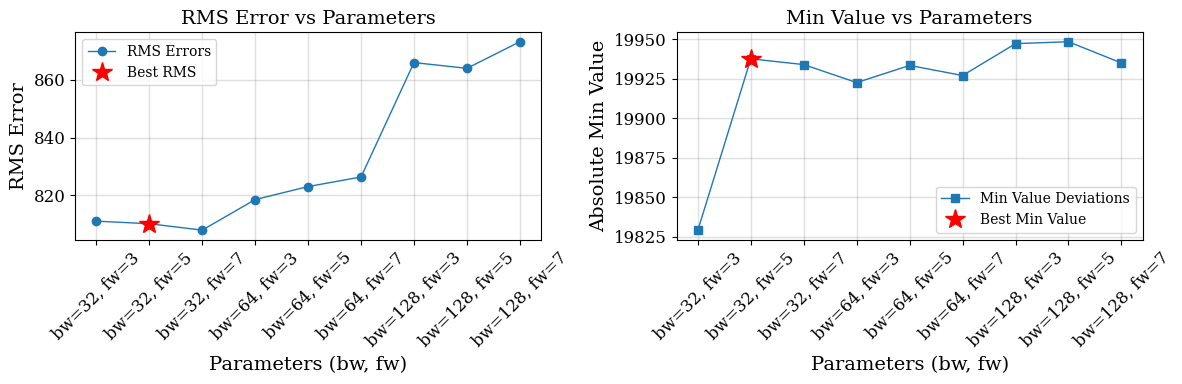

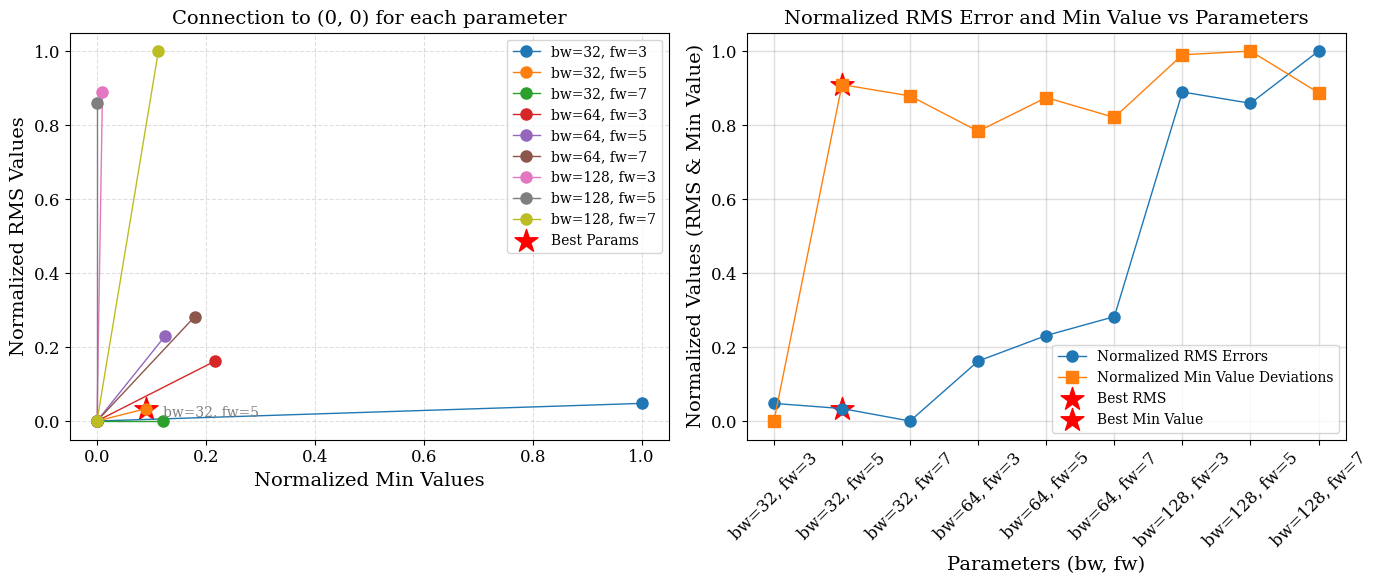

Processing file: /home/izm-ildana/astro/variable_search/data/alf-Cyg_11-12.11.1985_40m_70S-1.fit


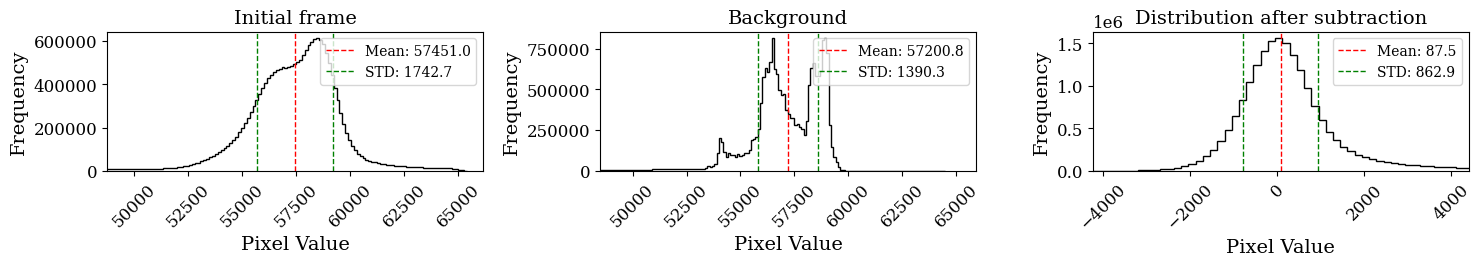

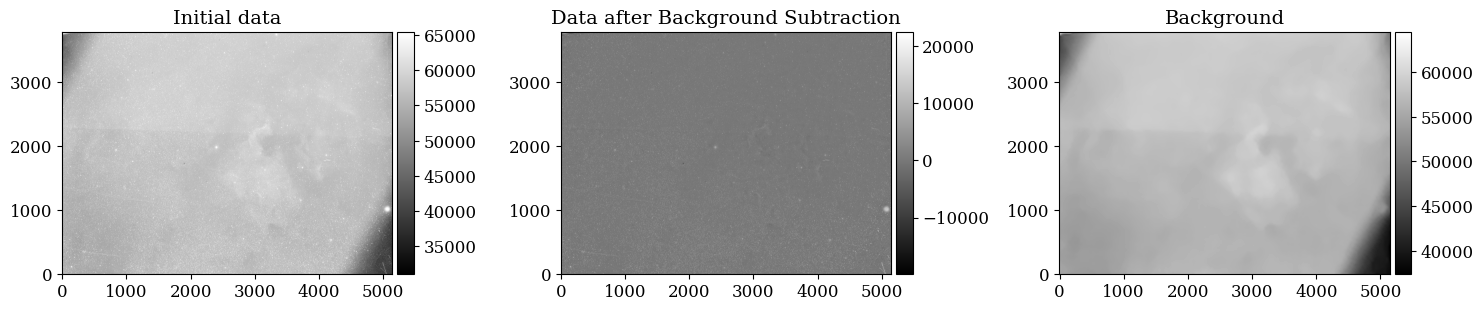

3520 objects found in segment 1


/tmp/ipykernel_3704/4029603454.py:171: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


4867 objects found in segment 2


/tmp/ipykernel_3704/4029603454.py:171: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


5140 objects found in segment 3


/tmp/ipykernel_3704/4029603454.py:171: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


8162 objects found in segment 4


/tmp/ipykernel_3704/4029603454.py:171: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)
Processing files: 100%|███████████████████████████| 1/1 [01:23<00:00, 83.53s/it]

Processed alf-Cyg_11-12.11.1985_40m_70S-1.fit (1/1) in 83.53 seconds.
-------------------------------------------


In [177]:
process_directory_export_objects(fits_directory, output_directory,scale='zscale')